[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
(120000,)
0
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]


/vol/optdcc/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:72: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


(120000,)
0
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]
[0.5 0.5]


/vol/optdcc/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:74: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


(120000,)
0


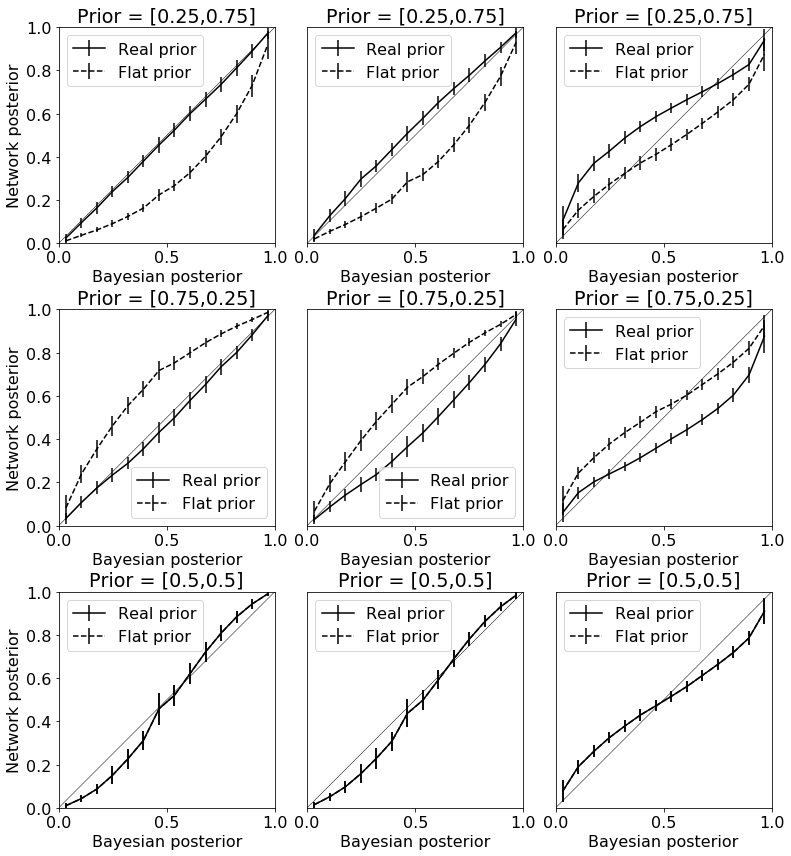

In [35]:
import sys
sys.path.append("/home/squax/GitHub/PNN/")
import torch
import numpy as np
import tqdm
import json

import matplotlib.pyplot as plt
import scipy.stats as sst

from tasks import *
from pytorch_networks import *
from tools import *
from pytorch_trainer import *

plt.rcParams.update({'font.size': 16})
# # model parameters
# N_input = 50
# N_hidden = 200

# # task parameters
# N_test = 20000
# N_class = 1
# N_cond = 2
# means=[-5, 5]
# sigmas=[9, 9]
# gain=np.array([0.37,0.90,1.81,2.82,3.57,4.00])*0.4 #*0.4
# prior=[0.75,0.25]

# model location
predictors = []
Qs = []
priors = []
tests = []

for task_id in xrange(1,4):
    task = 'class_1'
    
    param_loc = '/vol/ccnlab1/silqua/prirep/models/pytorch/param_NH200_cuenew_' + task + ''#2
    model_loc = '/vol/ccnlab1/silqua/prirep/models/pytorch/model_NH200_cuenew_' + task + ''#2
    
#     param_loc = '/vol/ccnlab1/silqua/prirep/models/pytorch/param_Cue2_GNH200_' + task + ''#2
#     model_loc = '/vol/ccnlab1/silqua/prirep/models/pytorch/model_Cue2_GNH200_' + task + ''#2
#     if task_id ==2:
#         param_loc = '/vol/ccnlab1/silqua/prirep/models/pytorch/param10_' + task + '_2'#2
#         model_loc = '/vol/ccnlab1/silqua/prirep/models/pytorch/model10_' + task + '_2'#2
    with open(param_loc+'.json','r') as fp:
        params = json.load(fp)   
    locals().update(params)
    N_test = 20000

    priors.append(prior)
    # define task
    test_data = conditional_classification_task(mu=means,sig2=sigmas,n_samples=N_test, sig2N = sig_phi,g=gain, n_input=N_input, pCin=prior,test=True,original=False)
#     test_data = classification_task(mu=means,sig2=sigmas,n_samples=N_test, sig2N = sig_phi,g=gain, n_input=N_input, pCin=prior,test=True,original=False)

    # define iterator
    test_iter = FixedIterator(test_data, batch_size=N_test*len(gain)*N_class*N_cond)

    # define model
#     model = Classifier(MLP(N_input+2,N_hidden, 2, bias = False))
    model = Classifier(MLPCUE(N_input,N_hidden, 2, bias = False))

    # setup optimizer
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)


    # load model
    model.load_state_dict(torch.load(model_loc))
    model.eval()
    if task_id==2:
        torch.nn.init.constant(model.predictor.cueg1.weight,0)
    elif task_id==3:
        torch.nn.init.constant(model.predictor.cue1.weight,0)


    #model.predictor.l2.b.data[[0,1]]=model.predictor.l2.b.data[[1,0]]
#     model = Classifier(model)
    # setup tester
    test = tester(model)
    
    # run tester
    test.run(test_iter)

    predictors.append(model.predictor)
    tests.append(test)
    # extract relevant data
    Q = extract_quantities(test,gain,N_test,6)
    print(np.sum(test.R,1)[np.squeeze(test.G==gain[0])].shape)
    print(len(test.R)/6-np.count_nonzero(np.sum(test.R,1)[np.squeeze(test.G==gain[0])]))

    Qs.append(Q)
    plt.figure(1,figsize = (18,12))

    for ii in xrange(3):
        HP11=bin_plot(test.real_posterior[ii*12*N_test:(ii+1)*12*N_test],test.test_posterior[ii*12*N_test:(ii+1)*12*N_test,0])
        HP21=bin_plot(test.real_posterior2[ii*12*N_test:(ii+1)*12*N_test],test.test_posterior[ii*12*N_test:(ii+1)*12*N_test,0])

        plt.subplot(3,5,task_id+5*ii)
        plt.errorbar(HP11['bins'],HP11['post_mean'],HP11['post_std'],fmt='k',label ='Real prior')
        plt.errorbar(HP21['bins'],HP21['post_mean'],HP21['post_std'],fmt='k--', label = 'Flat prior')
        plt.plot([0,1],[0,1],'k',linewidth=0.5)
        ax=plt.gca()
        ax.set_aspect(1)
        plt.xlim(0,1)
        plt.ylim(0,1)
        if ii == 0:
            plt.title('Prior = '+'[0.25,0.75]')
        elif ii ==1:
            plt.title('Prior = '+'[0.75,0.25]')
        elif ii ==2:
            plt.title('Prior = '+'[0.5,0.5]')
                      
        plt.xlabel('Bayesian posterior')
        plt.xticks([0,0.5,1])
        plt.legend()
        if task_id == 1:
            plt.ylabel('Network posterior')
        else:
            plt.yticks([])
plt.tight_layout()
plt.subplots_adjust(wspace=0.15)
#plt.savefig('/vol/ccnlab1/silqua/prirep/figures/pytorch/real_vs_flat_cue_rev.eps',format='eps')



0.7942354166666666
0.8261958333333334
0.8231583333333333
0.8288375
0.8073125
0.8275291666666666
0.6444166666666667
0.9382888888888888


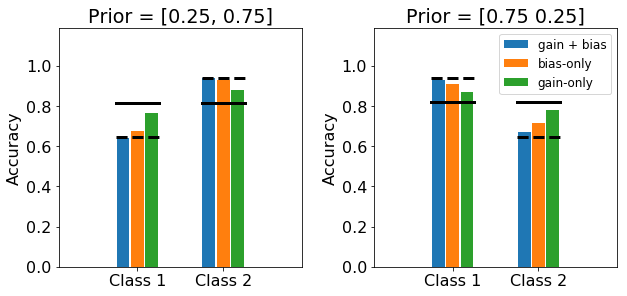

In [31]:
plt.rcParams.update({'font.size': 16})

plt.figure(2, figsize = (9,4.4))
acc1 = np.zeros(3)
acc2 = np.zeros(3)
acc3 = np.zeros(3)
acc4 = np.zeros(3)

acc1b = np.zeros(3)
acc2b = np.zeros(3)
acc3b = np.zeros(3)
acc4b = np.zeros(3)

acc1f = np.zeros(3)
acc2f = np.zeros(3)
acc3f = np.zeros(3)
acc4f = np.zeros(3)

for ii in xrange(3):
    correct = np.argmax(tests[ii].test_posterior,1)==tests[ii].C
    acc1[ii] = np.mean(correct[:1*len(tests[ii].C)/6])
    acc2[ii] = np.mean(correct[1*len(tests[ii].C)/6:2*len(tests[ii].C)/6])
    acc3[ii] = np.mean(correct[2*len(tests[ii].C)/6:3*len(tests[ii].C)/6])
    acc4[ii] = np.mean(correct[3*len(tests[ii].C)/6:4*len(tests[ii].C)/6])


    print(np.mean(correct[:2*len(tests[ii].C)/3]))
    print(np.mean(correct[2*len(tests[ii].C)/3:len(tests[ii].C)]))

for ii in xrange(3):
    correctb = (1-np.rint(tests[ii].real_posterior))==tests[ii].C
    acc1b[ii] = np.mean(correctb[:1*len(tests[ii].C)/6])
    acc2b[ii] = np.mean(correctb[1*len(tests[ii].C)/6:2*len(tests[ii].C)/6])
    acc3b[ii] = np.mean(correctb[2*len(tests[ii].C)/6:3*len(tests[ii].C)/6])
    acc4b[ii] = np.mean(correctb[3*len(tests[ii].C)/6:4*len(tests[ii].C)/6])

for ii in xrange(3):
    correctf = (1-np.rint(tests[ii].real_posterior2))==tests[ii].C
    acc1f[ii] = np.mean(correctf[:1*len(tests[ii].C)/6])
    acc2f[ii] = np.mean(correctf[1*len(tests[ii].C)/6:2*len(tests[ii].C)/6])
    acc3f[ii] = np.mean(correctf[2*len(tests[ii].C)/6:3*len(tests[ii].C)/6])
    acc4f[ii] = np.mean(correctf[3*len(tests[ii].C)/6:4*len(tests[ii].C)/6])
    
print(np.mean(acc1b))
print(np.mean(acc2b))
    
plt.subplot(1,2,1)
plt.bar([0.9,2.1],[acc1[0],acc2[0]], width = 0.18, color = 'C0')
plt.bar([1.1,2.3],[acc1[2],acc2[2]], width = 0.18, color = 'C1')
plt.bar([1.3,2.5],[acc1[1],acc2[1]], width = 0.18, color = 'C2')
plt.plot([0.8,1.4],[acc1b[1],acc1b[1]],'--k',linewidth=3)
plt.plot([2.0,2.6],[acc2b[1],acc2b[1]],'--k',linewidth=3)
plt.plot([0.8,1.4],[acc1f[1],acc1f[1]],'-k',linewidth=3)
plt.plot([2.0,2.6],[acc1f[1],acc1f[1]],'-k',linewidth=3)

plt.xlim([0,3.4])
plt.ylim([0,1.19])

#     plt.xlabel('Class')
plt.xticks([1.1,2.3],['Class 1','Class 2'])
plt.ylabel('Accuracy')

plt.title('Prior = '+str(priors[ii]))
plt.tight_layout()

plt.subplot(1,2,2)
plt.bar([0.9,2.1],[acc3[0],acc4[0]], width = 0.18, color = 'C0')
plt.bar([1.1,2.3],[acc3[2],acc4[2]], width = 0.18, color = 'C1')
plt.bar([1.3,2.5],[acc3[1],acc4[1]], width = 0.18, color = 'C2')
plt.legend(['gain + bias','bias-only','gain-only'],prop={'size': 12})

plt.plot([0.8,1.4],[acc3b[1],acc3b[1]],'--k',linewidth=3)
plt.plot([2.0,2.6],[acc4b[1],acc4b[1]],'--k',linewidth=3)
plt.plot([0.8,1.4],[acc3f[1],acc3f[1]],'-k',linewidth=3)
plt.plot([2.0,2.6],[acc3f[1],acc3f[1]],'-k',linewidth=3)
plt.xlim([0,3.4])
plt.ylim([0,1.19])

#     plt.xlabel('Class')
plt.xticks([1.1,2.3],['Class 1','Class 2'])
plt.ylabel('Accuracy')

plt.title('Prior = '+str(1- np.array(priors[ii])))
plt.tight_layout()
#plt.savefig('/vol/ccnlab1/silqua/prirep/figures/pytorch/Error_vs_prior_cue_new2_rev.eps',format='eps')


(6, 120000)


AttributeError: 'MLPCUE' object has no attribute 'cue2'

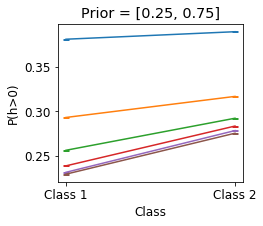

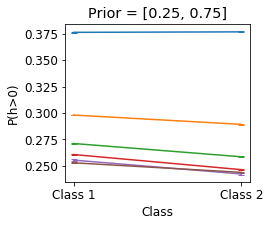

In [7]:
print(Qs[0]['sp_all'].shape)
plt.rcParams.update({'font.size': 12})

qty_str = 'sp_all'
plt.figure(figsize=(15,3.3))
for task_id in xrange(0,1):
    plt.subplot(151+task_id)
    for ii in xrange(len(gain)):
        mean1=np.nanmean(Qs[task_id][qty_str][ii,:N_test])
        mean2=np.nanmean(Qs[task_id][qty_str][ii,N_test:2*N_test])

        std1=np.nanstd(Qs[task_id][qty_str][ii,:N_test])/np.sqrt(N_test)
        std2=np.nanstd(Qs[task_id][qty_str][ii,N_test:2*N_test])/np.sqrt(N_test)
        plt.errorbar([1,2],[mean1,mean2],[std1,std2],label=('Gain = '+str(gain[ii])),capsize=3)
#         plt.ylim([0.3,0.7])
        plt.xticks([1,2],['Class 1','Class 2'])
        plt.xlabel('Class')
#         plt.xlim([0.8,2.2])
        plt.title('Prior = '+str(priors[task_id]))

        if task_id == 0:
            plt.ylabel('P(h>0)')
        else:
            plt.yticks([])
        if task_id == 4:
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
# plt.savefig('/vol/ccnlab1/silqua/prirep/figures/sparse_diff_prior2.eps',format='eps')

plt.figure(figsize=(15,3.3))
for task_id in xrange(0,1):
    plt.subplot(151+task_id)
    for ii in xrange(len(gain)):
        mean1=np.nanmean(Qs[task_id][qty_str][ii,2*N_test:3*N_test])
        mean2=np.nanmean(Qs[task_id][qty_str][ii,3*N_test:4*N_test])

        std1=np.nanstd(Qs[task_id][qty_str][ii,2*N_test:3*N_test])/np.sqrt(N_test)
        std2=np.nanstd(Qs[task_id][qty_str][ii,3*N_test:4*N_test])/np.sqrt(N_test)
        plt.errorbar([1,2],[mean1,mean2],[std1,std2],label=('Gain = '+str(gain[ii])),capsize=3)
#         plt.ylim([0.3,0.7])
        plt.xticks([1,2],['Class 1','Class 2'])
        plt.xlabel('Class')
#         plt.xlim([0.8,2.2])
        plt.title('Prior = '+str(priors[task_id]))

        if task_id == 0:
            plt.ylabel('P(h>0)')
        else:
            plt.yticks([])
        if task_id == 4:
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
# plt.savefig('/vol/ccnlab1/silqua/prirep/figures/sparse_diff_prior2.eps',format='eps')
print(predictors[0].cue2.weight.data.numpy())
plt.figure()
plt.hist(predictors[4].l2.weight.data.numpy().flatten())

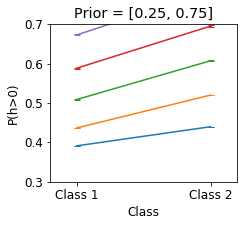

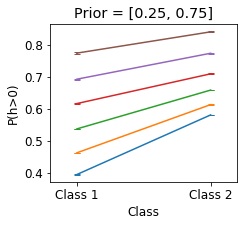

In [6]:
plt.rcParams.update({'font.size': 12})

qty_str = 'H_act_mean_all'
plt.figure(figsize=(15,3.3))
for task_id in xrange(0,1):
    plt.subplot(151+task_id)
    for ii in xrange(len(gain)):
        mean1=np.nanmean(Qs[task_id][qty_str][ii,:N_test])
        mean2=np.nanmean(Qs[task_id][qty_str][ii,N_test:2*N_test])

        std1=np.nanstd(Qs[task_id][qty_str][ii,:N_test])/np.sqrt(N_test)
        std2=np.nanstd(Qs[task_id][qty_str][ii,N_test:2*N_test])/np.sqrt(N_test)
        plt.errorbar([1,2],[mean1,mean2],[std1,std2],label=('Gain = '+str(gain[ii])),capsize=3)
        plt.ylim([0.3,0.7])
        plt.xticks([1,2],['Class 1','Class 2'])
        plt.xlabel('Class')
        plt.xlim([0.8,2.2])
        plt.title('Prior = '+str(priors[task_id]))

        if task_id == 0:
            plt.ylabel('P(h>0)')
        else:
            plt.yticks([])
        if task_id == 4:
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
# plt.savefig('/vol/ccnlab1/silqua/prirep/figures/sparse_diff_prior2.eps',format='eps')

plt.figure(figsize=(15,3.3))
for task_id in xrange(0,1):
    plt.subplot(151+task_id)
    for ii in xrange(len(gain)):
        mean1=np.nanmean(Qs[task_id][qty_str][ii,2*N_test:3*N_test])
        mean2=np.nanmean(Qs[task_id][qty_str][ii,5*N_test:6*N_test])

        std1=np.nanstd(Qs[task_id][qty_str][ii,2*N_test:3*N_test])/np.sqrt(N_test)
        std2=np.nanstd(Qs[task_id][qty_str][ii,3*N_test:4*N_test])/np.sqrt(N_test)
        plt.errorbar([1,2],[mean1,mean2],[std1,std2],label=('Gain = '+str(gain[ii])),capsize=3)
#         plt.ylim([0.3,0.7])
        plt.xticks([1,2],['Class 1','Class 2'])
        plt.xlabel('Class')
        plt.xlim([0.8,2.2])
        plt.title('Prior = '+str(priors[task_id]))

        if task_id == 0:
            plt.ylabel('P(h>0)')
        else:
            plt.yticks([])
        if task_id == 4:
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
# plt.savefig('/vol/ccnlab1/silqua/prirep/figures/sparse_diff_prior2.eps',format='eps')

In [5]:
ii=0
output1 = np.dot(tests[ii].H,predictors[ii].l2.weight.data.numpy().T)
print(output1.shape)

print(Qs[0]['sp_all'].shape)
plt.rcParams.update({'font.size': 12})


print(np.mean(output1[12:N_test:18*N_test,:],0))
print(np.mean(output1[18*N_test:24*N_test,:],0))
print(predictors[4].cue2.weight.data.numpy())
input1 = np.ones((1,52)).astype('float32')
input1[0,50]=1
print(input1)
print(predictors[0](Variable(torch.from_numpy(input1))))
print((1-(np.asarray([0,1])+0.5)/2))

(720000, 2)
(6, 120000)
[ 0.04568722 -0.04670107]
[-0.3386182  0.3383891]
[[-0.36436665  0.4987308 ]
 [ 0.44152614  0.06753955]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1.]]
tensor([[0.1408, 0.3701]], grad_fn=<AddBackward0>)
[0.75 0.25]


In [3]:
W_hid_all = np.zeros((5,2,2))
W_hid_std = np.zeros((5,2,2))

N_all =np.zeros((5,2))
for ii in xrange(1):
    W = predictors[ii].l1.weight.data.numpy()
    W2 = predictors[ii].l2.weight.data.numpy()


    s = predictors[ii].p1.data.numpy()
    #b2 = model.predictor.l2.b.data

    idx = np.where(W2[0,:]>W2[1,:])
    idx2 = np.where(W2[0,:]<W2[1,:])
    N_all[ii,0] = len(idx[0][:])
    N_all[ii,1] = len(idx2[0][:])

    W_hid_all[ii,0,0] = np.mean(W[idx,50].flatten())
    W_hid_all[ii,0,1] = np.mean(W[idx2,50].flatten())
    W_hid_all[ii,1,0] = np.mean(W[idx,51].flatten())
    W_hid_all[ii,1,1] = np.mean(W[idx2,51].flatten())        
    W_hid_std[ii,0,0] = np.std(W[idx,50].flatten())/np.sqrt(len(idx[0]))
    W_hid_std[ii,0,1] = np.std(W[idx2,50].flatten())/np.sqrt(len(idx2[0]))
    W_hid_std[ii,1,0] = np.std(W[idx,51].flatten())/np.sqrt(len(idx[0]))
    W_hid_std[ii,1,1] = np.std(W[idx2,51].flatten())/np.sqrt(len(idx2[0]))
plt.rcParams.update({'font.size': 16})

plt.figure(figsize = (4.5,4.0))
x = np.array([0.25,0.75])
plt.errorbar(x,W_hid_all[0,:,0],W_hid_std[0,:,0])
plt.errorbar(x,W_hid_all[0,:,1],W_hid_std[0,:,1])

plt.xlim(0.2,0.8)
plt.ylim(-0.2,0.2)
plt.xlabel('P(C=1)')
plt.ylabel(r'$\langle I_{hidden} \rangle$ (a.u.)')
plt.legend([r'$W_{out}(C=1)>W_{out}(C=2)$',r'$W_{out}(C=1)<W_{out}(C=2)$'],prop={'size': 8},loc= 'upper center')
plt.tight_layout()
# plt.savefig('/vol/ccnlab1/silqua/prirep/figures/pytorch/hidden_input_cue.eps',format='eps')


IndexError: index 50 is out of bounds for axis 1 with size 50

Ttest_indResult(statistic=-6.731981933188895, pvalue=1.7672883337368694e-10)
Ttest_indResult(statistic=5.643784317060515, pvalue=5.7021588148052155e-08)
Ttest_indResult(statistic=-8.172866757957616, pvalue=3.5284777554867e-14)
Ttest_indResult(statistic=6.326790623740947, pvalue=1.6355520383080231e-09)


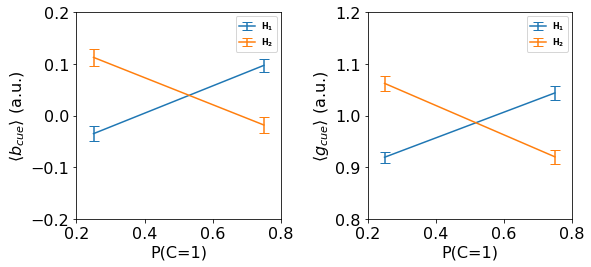

In [36]:
from matplotlib import rc
rc('text', usetex=False)

W_hid_all = np.zeros((5,2,2))
G_hid_all = np.zeros((5,2,2))
W_hid_std = np.zeros((5,2,2))
G_hid_std = np.zeros((5,2,2))

N_all =np.zeros((5,2))
for ii in xrange(1):
    W = predictors[ii].cue1.weight.data.numpy()
    G = predictors[ii].cueg1.weight.data.numpy()
    W2 = predictors[ii].l2.weight.data.numpy()


    s = predictors[ii].p1.data.numpy()
    #b2 = model.predictor.l2.b.data

    idx = np.where(W2[0,:]>W2[1,:])
    idx2 = np.where(W2[0,:]<W2[1,:])
    N_all[ii,0] = len(idx[0][:])
    N_all[ii,1] = len(idx2[0][:])

    W_hid_all[ii,0,0] = np.mean(W[idx,0].flatten())
    W_hid_all[ii,0,1] = np.mean(W[idx2,0].flatten())
    W_hid_all[ii,1,0] = np.mean(W[idx,1].flatten())
    W_hid_all[ii,1,1] = np.mean(W[idx2,1].flatten())        
    W_hid_std[ii,0,0] = np.std(W[idx,0].flatten())/np.sqrt(len(idx[0]))
    W_hid_std[ii,0,1] = np.std(W[idx2,0].flatten())/np.sqrt(len(idx2[0]))
    W_hid_std[ii,1,0] = np.std(W[idx,1].flatten())/np.sqrt(len(idx[0]))
    W_hid_std[ii,1,1] = np.std(W[idx2,1].flatten())/np.sqrt(len(idx2[0]))
    
    G_hid_all[ii,0,0] = np.mean(G[idx,0].flatten())
    G_hid_all[ii,0,1] = np.mean(G[idx2,0].flatten())
    G_hid_all[ii,1,0] = np.mean(G[idx,1].flatten())
    G_hid_all[ii,1,1] = np.mean(G[idx2,1].flatten())        
    G_hid_std[ii,0,0] = np.std(G[idx,0].flatten())/np.sqrt(len(idx[0]))
    G_hid_std[ii,0,1] = np.std(G[idx2,0].flatten())/np.sqrt(len(idx2[0]))
    G_hid_std[ii,1,0] = np.std(G[idx,1].flatten())/np.sqrt(len(idx[0]))
    G_hid_std[ii,1,1] = np.std(G[idx2,1].flatten())/np.sqrt(len(idx2[0]))
    
plt.rcParams.update({'font.size': 16})

plt.figure(figsize = (8.5,4.0))
plt.subplot(1,2,1)
x = np.array([0.25,0.75])
plt.errorbar(x,W_hid_all[0,:,0],W_hid_std[0,:,0],capsize=5)
plt.errorbar(x,W_hid_all[0,:,1],W_hid_std[0,:,1],capsize=5)

plt.xlim(0.2,0.8)
plt.ylim(-0.2,0.2)
plt.xlabel('P(C=1)')
plt.ylabel(r'$\langle {b}_{cue} \rangle$ (a.u.)')
plt.legend([r'$\bf{H_1}$',r'$\bf{H_2}$'],prop={'size': 8},loc= 'upper right')

plt.subplot(1,2,2)
x = np.array([0.25,0.75])
plt.errorbar(x,G_hid_all[0,:,0]+1,G_hid_std[0,:,0],capsize=5)
plt.errorbar(x,G_hid_all[0,:,1]+1,G_hid_std[0,:,1],capsize=5)

plt.xlim(0.2,0.8)
plt.ylim(0.8,1.2)
plt.xlabel('P(C=1)')
plt.ylabel(r'$\langle {g}_{cue} \rangle$ (a.u.)')
plt.legend([r'$\bf{H_1}$',r'$\bf{H_2}$'],prop={'size': 8},loc= 'upper right')
plt.tight_layout()
# plt.savefig('/vol/ccnlab1/silqua/prirep/figures/pytorch/bias_gain_cue_new.eps',format='eps')
print(sst.ttest_ind(W[idx,0].flatten(),W[idx2,0].flatten()))
print(sst.ttest_ind(W[idx,1].flatten(),W[idx2,1].flatten()))
print(sst.ttest_ind(G[idx,0].flatten(),G[idx2,0].flatten()))
print(sst.ttest_ind(G[idx,1].flatten(),G[idx2,1].flatten()))